# Analyze network balance with frustration index an algebraic conflict

In [1]:
import networkx as nx
import pandas as pd
from matplotlib import pyplot as plt
import tqdm
import os
from tqdm import tqdm
import glob
import re
from collections import Counter

import sys
sys.path.append('../local/bin/')

from sygno.signed_networkx import draw_signed_networkx

____________________

Retrieve Clausen and Peltzman categories

In [2]:
dataset_folder = '../dataset/'
congress_path = dataset_folder + 'download_votes_merged/*'
clausen_cat = 'Foreign_and_Defense_Policy'

In [3]:
# Initialize a weighted bipartite graph
G = nx.Graph()

# Iterate through each CSV file
for csv_file in tqdm(glob.glob(congress_path)):
    # Read the CSV file into a pandas DataFrame
    df = pd.read_csv(csv_file)
    
    # Count the occurrences of each pair of Clausen and Peltzman categories
    counts = df.groupby(["Clausen", "Peltzman"]).size().reset_index(name="count")
    
    # Add edges to the graph with weights based on the counts
    for _, row in counts.iterrows():
        clausen_category = row["Clausen"]
        peltzman_category = row["Peltzman"]
        count = row["count"]
        
        G.add_node(clausen_category, bipartite=0)
        G.add_node(peltzman_category, bipartite=1)
        G.add_edge(clausen_category, peltzman_category, weight=count)

# Now you have a weighted bipartite graph (G) with edges representing the co-occurrences
# between Clausen and Peltzman categories and weights representing the number of occurrences.

  0%|          | 0/41 [00:00<?, ?it/s]

  5%|▍         | 2/41 [00:01<00:37,  1.03it/s]/tmp/ipykernel_8905/3165551236.py:7: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(csv_file)
100%|██████████| 41/41 [00:45<00:00,  1.10s/it]


In [4]:
print('Clausen categories: ', [n for n in G.nodes() if G.nodes[n]['bipartite'] == 0])
print('Number of Clausen categories: ', len([n for n in G.nodes() if G.nodes[n]['bipartite'] == 0]))

print('Peltzman categories: ', [n for n in G.nodes() if G.nodes[n]['bipartite'] == 1])
print('Number of Peltzman categories: ', len([n for n in G.nodes() if G.nodes[n]['bipartite'] == 1]))

Clausen categories:  ['Agriculture', 'Civil Liberties', 'Foreign and Defense Policy', 'Government Management', 'Miscellaneous Policy', 'Social Welfare']
Number of Clausen categories:  6
Peltzman categories:  ['Budget Special Interest', 'Regulation General Interest', 'Regulation Special Interest', 'D. C.', 'Domestic Social Policy', 'Defense Policy Budget', 'Defense Policy Resolutions', 'Foreign Policy Budget', 'Foreign Policy Resolutions', 'Budget General Interest', 'Government Organization', 'Internal Organization', 'Indian Affairs']
Number of Peltzman categories:  13


In [5]:
clausen_cat_list = [n for n in G.nodes() if G.nodes[n]['bipartite'] == 0]
peltzman_cat_list = [n for n in G.nodes() if G.nodes[n]['bipartite'] == 1]

clausen_cat_dic = {x: re.sub(' ', '_', x) for x in clausen_cat_list}
peltzman_cat_dic = {x: re.sub(' ', '_', x) for x in peltzman_cat_list}

_________________________

Load the dataframe created in the *data_parsing.ipynb* containing all the information about the members of the congresses

Create a dictionary that links each icpsr to a party. Notice that an icpsr identifies uniquely a legislator, but a legislator can have more than one icpsr. This is because the icpsr is assigned to a legislator for each congress. For example, if a legislator is elected in 2000 and reelected in 2002, he will have two different icpsr, one for each congress. We will use the icpsr of the first congress in which the legislator was elected.

In [6]:
thresholds_path = '../dataset/thresholds/'
edgelists_path = '../dataset/edgelists/'

In [7]:
pol = pd.read_csv(dataset_folder + 'members.csv')
pol['color'] = pol['party_name'].apply(lambda x: 'firebrick' if 'Republican' in x else ('royalblue' if 'Democrat' in x else 'yellow'))
pol_dic = pol[['icpsr', 'party_name']].set_index('icpsr').to_dict(orient="index")
pol.head()

,icpsr,congress,party_code,bioname,state_abbrev,party_name,color
0,1,[82],[200],"AANDAHL, Fred George",ND,['Republican'],firebrick
1,2,"[80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 9...",[100],"ABBITT, Watkins Moorman",VA,['Democrat'],royalblue
2,3,"[28, 29, 30]",[29],"ABBOTT, Amos",MA,['Whig'],yellow
3,4,"[50, 51, 52, 53, 54]",[100],"ABBOTT, Jo (Joseph)",TX,['Democrat'],royalblue
4,5,"[15, 16, 17, 18]","[7777, 13]","ABBOT, Joel",GA,"['Crawford Republican', 'Democrat-Republican']",firebrick


In [8]:
icpsr2bioname = pol.set_index('icpsr')['bioname'].to_dict()

In [9]:
def draw_graph(df, pol_dic):

    # Arguments:
	# df ---> edgelist
	# pol_dic ---> dictionary where key is icpsr and value is party_name
	# congress_num ---> congress number

    G = nx.from_pandas_edgelist(df, 'source', 'target', ['weight'])

    nodeData = {list(g.icpsr)[0]: {'state': list(g.state_abbrev)[0], 'party': list(g.party_name)[0], 'color': list(g.color)[0],  'congress': list(g.congress)[0], 'name': list(g.bioname)[0]} for k, g in pol.groupby('icpsr')}
    nx.set_node_attributes(G, nodeData)

    colors = [node[1]['color'] for node in G.nodes(data=True)]
    
    fig, ax, pos, least_eigenvalue = draw_signed_networkx(G, node_color=colors, compact = True, theme="white", normalize=True, scale='log', jittering=0.01, margin=0.2, show_rotation=False, highlight_edges='frustrated', remove_n_outliers=3, sort_by='party')
    
    # Dictionary to store x position of each node with icpsr as the value
    x_positions = {int(p): {'x': pos[p].x, 'icpsr': int(p), 'bioname':icpsr2bioname[int(p)] , 'party': pol_dic[int(p)]['party_name']} for p in pos.keys()}

    # print infos about users per party
    positions_party = {'pos': {'Democrat': 0,'Republican':0}, 'neg': {'Democrat': 0,'Republican':0}}
    for p in pos.keys():
        if pos[p].x > 0:
            if pol_dic[int(p)]['party_name'] == 'Democrat' or pol_dic[int(p)]['party_name'] == 'Republican':
                positions_party['pos'][pol_dic[int(p)]['party_name']] += 1
        else:
            if pol_dic[int(p)]['party_name'] == 'party_name' or pol_dic[int(p)]['party_name'] == 'Republican':
                positions_party['neg'][pol_dic[int(p)]['party_name']] += 1

    plt.text(0, .04, "Rep: "+str(positions_party['neg']['Republican']), fontsize=13, transform=ax.transAxes, color="ghostwhite")
    plt.text(0, .09, "Dem: "+str(positions_party['neg']['Democrat']), fontsize=13, transform=ax.transAxes, color="ghostwhite")

    plt.text(0.9, .04, "Rep: "+str(positions_party['pos']['Republican']), fontsize=13, transform=ax.transAxes, color="ghostwhite")
    plt.text(0.9, .09, "Dem: "+str(positions_party['pos']['Democrat']), fontsize=13, transform=ax.transAxes, color="ghostwhite")
    

    plt.show()

    return least_eigenvalue, x_positions

In [10]:
def read_edgelist(folder, threshold_pos, threshold_neg):
    # read edgelist
    df = pd.read_csv(folder)
    df_pos = df.loc[(df['weight']==1)&(df['perc']>threshold_pos)].copy()
    df_neg = df.loc[(df['weight']==-1)&(df['perc']>threshold_neg)].copy()
    df = pd.concat([df_pos, df_neg])
    

    least_eigen, x_pos_dic = draw_graph(df, pol_dic)

    return least_eigen, x_pos_dic

In [11]:
def findquadrants(x_pos_dic):
    # Separate the dictionary into two sets based on x position
    positive_x_set = {k: v['bioname'] for k, v in x_pos_dic.items() if v['x'] > 0}
    negative_x_set = {k: v['bioname'] for k, v in x_pos_dic.items() if v['x'] < 0}

    # Find the majority party in each set
    def find_majority_party(data_set):
        parties = [item['party'] for item in x_pos_dic.values() if item['bioname'] in data_set.values()]
        party_counts = Counter(parties)
        majority_party = party_counts.most_common(1)[0][0]
        return majority_party

    # Get the majority parties for each set
    majority_party_positive = find_majority_party(positive_x_set)
    majority_party_negative = find_majority_party(negative_x_set)

    print("Majority party in positive x set: ", majority_party_positive)
    print("Majority party in negative x set: ", majority_party_negative)

    if 'Democrat' in majority_party_negative and 'Republican' in majority_party_positive:
        maj_democrats = negative_x_set
        maj_republicans = positive_x_set
    elif 'Democrat' in majority_party_positive and 'Republican' in majority_party_negative:
        maj_democrats = positive_x_set
        maj_republicans = negative_x_set
    else:
        raise ValueError('Something went wrong. The majority parties are not what we expected.')

    return maj_democrats, maj_republicans

In [12]:
def findsets(x_pos_dic):
    
    maj_democrats, maj_republicans = findquadrants(x_pos_dic)

    # find mispositioned users
    misplaced_democrats = set()
    misplaced_republicans = set()

    for k, v in x_pos_dic.items():
        if 'Democrat' in v['party']:
            if v['bioname'] in maj_republicans.values():
                misplaced_democrats.add((v['bioname'], v['x']))
        else:
            if v['bioname'] in maj_democrats.values():
                misplaced_republicans.add((v['bioname'], v['x']))

    return misplaced_democrats, misplaced_republicans

In [13]:
def printinfo(cong, misplaced_democrats, misplaced_republicans, successive_misplaced_democrats, successive_misplaced_republicans):
    print('-------------------------------------------')
    print('Congress: ', cong)
    print('N. misplaced Democrats: ', len(misplaced_democrats))
    print('N. misplaced Republicans: ', len(misplaced_republicans))
    print('Intersection with successive congress: ')
    print('Among Democrats: ', len(misplaced_democrats.intersection(successive_misplaced_democrats)))
    print('Among Republicans: ', len(misplaced_republicans.intersection(successive_misplaced_republicans)))

    print('List of misplaced Democrats: ', misplaced_democrats)
    print('List of misplaced Republicans: ', misplaced_republicans)
    print('Conserved misplaced Democrats: ', misplaced_democrats.intersection(successive_misplaced_democrats))
    print('Conserved misplaced Republicans: ', misplaced_republicans.intersection(successive_misplaced_republicans))

    print('party switchers: ', misplaced_democrats.intersection(successive_misplaced_republicans), misplaced_republicans.intersection(successive_misplaced_democrats))

_______________________________

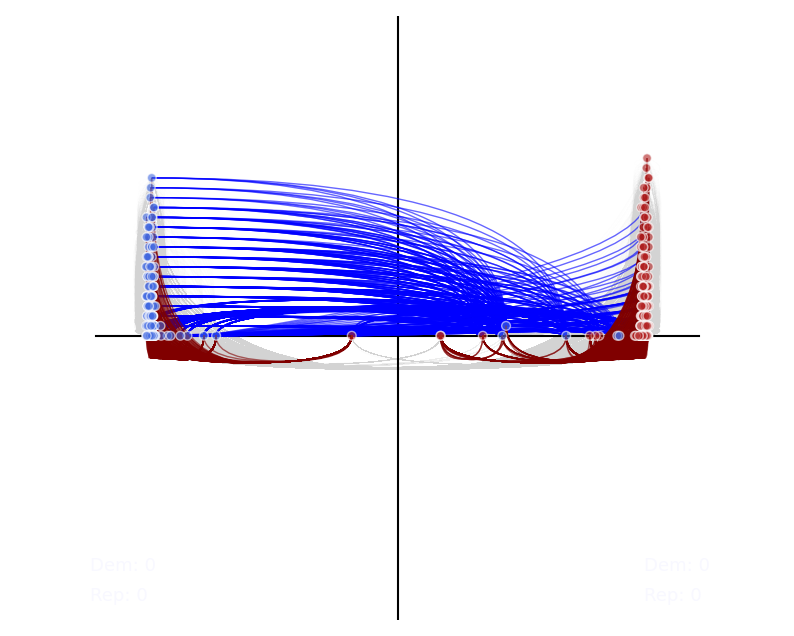

Majority party in positive x set:  ['Democrat']
Majority party in negative x set:  ['Republican']
113th Congress
N. misplaced Democrats:  5
N. misplaced Republicans:  1
List of misplaced Democrats:  {('NORCROSS, Donald', -0.49980730684722907), ('BARROW, John', -1.0485182617759314), ('McINTYRE, Mike', -1.0583407453057563), ('BARBER, Ron', -0.8044805400083042), ('ADAMS, Alma', -0.5177277023251514)}
List of misplaced Republicans:  {('MASSIE, Thomas', 0.21824131247368134)}


In [14]:
cong = '113'
temp = pd.read_csv('../dataset/thresholds/house_clausen_thresholds/'+clausen_cat+'/' + cong + '_dic_thresholds_norm.csv')
threshold_pos = temp.iloc[0]['pos_threshold']
threshold_neg = temp.iloc[0]['neg_threshold']

_, x_pos_dic_113 = read_edgelist('../dataset/edgelists/votes_house_clausen_edges/'+clausen_cat+'/congress_' + cong + '.csv', threshold_pos, threshold_neg)

misplaced_democrats_113, misplaced_republicans_113 = findsets(x_pos_dic_113)

print('113th Congress')
print('N. misplaced Democrats: ', len(misplaced_democrats_113))
print('N. misplaced Republicans: ', len(misplaced_republicans_113))
print('List of misplaced Democrats: ', misplaced_democrats_113)
print('List of misplaced Republicans: ', misplaced_republicans_113)

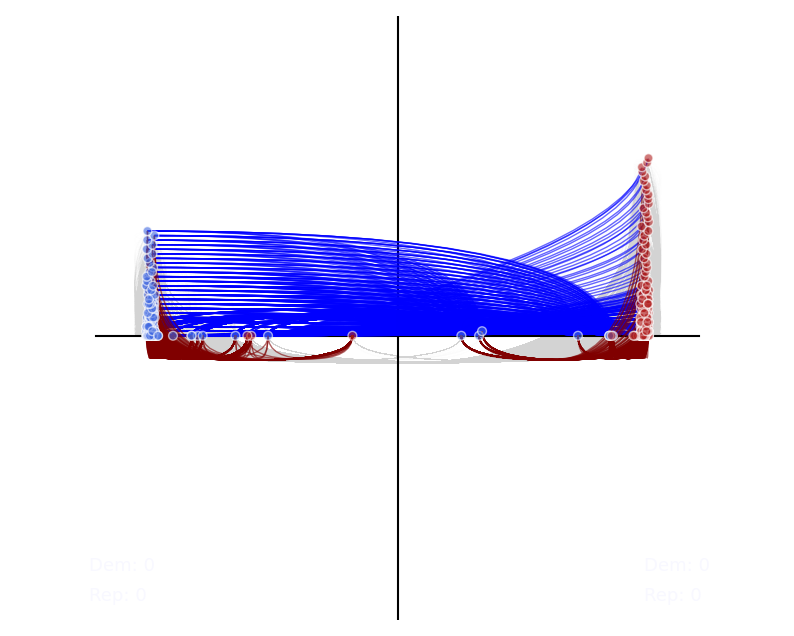

Majority party in positive x set:  ['Democrat']
Majority party in negative x set:  ['Republican']
-------------------------------------------
Congress:  112
N. misplaced Democrats:  8
N. misplaced Republicans:  3
Intersection with successive congress: 
Among Democrats:  0
Among Republicans:  0
List of misplaced Democrats:  {('ROSS, Michael Avery', -1.0124408156433398), ('BOREN, Daniel David', -1.027456349612856), ('SHULER, Heath', -1.0103573501772083), ('CURSON, David Alan', -0.3889632987175748), ('ALTMIRE, Jason', -0.30443509473226404), ('BARBER, Ron', -0.8605874891406216), ('DelBENE, Suzan K.', -0.40323227618261914), ('MATHESON, James David (Jim)', -1.009337171500324)}
List of misplaced Republicans:  {('PAUL, Ronald Ernest', 0.6972624989814293), ('JONES, Walter Beaman, Jr.', 0.7160391427035686), ('AMASH, Justin', 0.2149984238881142)}
Conserved misplaced Democrats:  set()
Conserved misplaced Republicans:  set()
party switchers:  set() set()


In [15]:
cong = '112'
temp = pd.read_csv('../dataset/thresholds/house_clausen_thresholds/'+clausen_cat+'/' + cong + '_dic_thresholds_norm.csv')
threshold_pos = temp.iloc[0]['pos_threshold']
threshold_neg = temp.iloc[0]['neg_threshold']

_, x_pos_dic_112 = read_edgelist('../dataset/edgelists/votes_house_clausen_edges/'+clausen_cat+'/congress_' + cong + '.csv', threshold_pos, threshold_neg)

misplaced_democrats_112, misplaced_republicans_112 = findsets(x_pos_dic_112)

printinfo(cong, misplaced_democrats_112, misplaced_republicans_112, misplaced_democrats_113, misplaced_republicans_113)


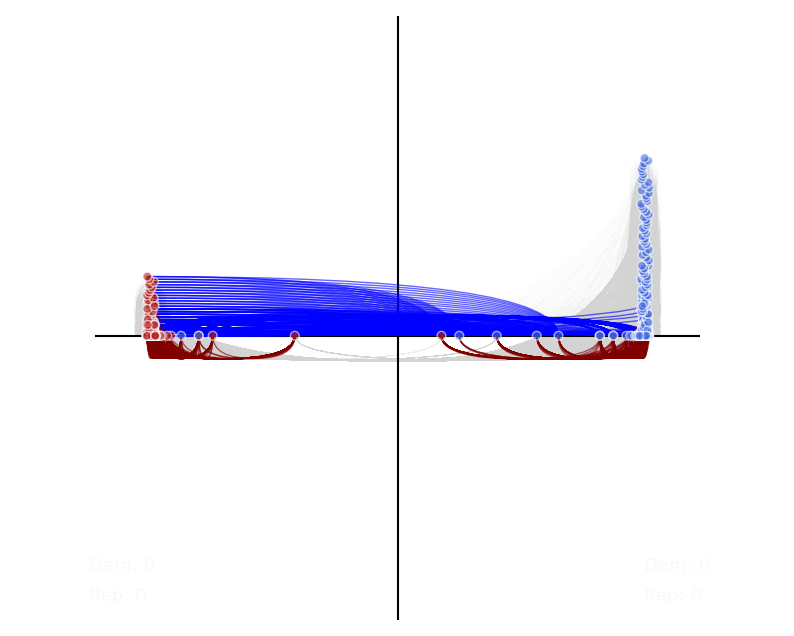

Majority party in positive x set:  ['Republican']
Majority party in negative x set:  ['Democrat']
-------------------------------------------
Congress:  111
N. misplaced Democrats:  3
N. misplaced Republicans:  2
Intersection with successive congress: 
Among Democrats:  0
Among Republicans:  0
List of misplaced Democrats:  {('BRIGHT, Bobby Neal, Sr.', 1.0320651476209148), ('MINNICK, Walt', 0.9486651606821275), ('GRIFFITH, Parker', -0.9636448799545563)}
List of misplaced Republicans:  {('GRIFFITH, Parker', 1.1558627288112724), ('DJOU, Charles', -0.20970227440446784)}
Conserved misplaced Democrats:  set()
Conserved misplaced Republicans:  set()
party switchers:  set() set()


In [16]:
cong = '111'

temp = pd.read_csv('../dataset/thresholds/house_clausen_thresholds/'+clausen_cat+'/' + cong + '_dic_thresholds_norm.csv')
threshold_pos = temp.iloc[0]['pos_threshold']
threshold_neg = temp.iloc[0]['neg_threshold'] 

_, x_pos_dic_111 = read_edgelist('../dataset/edgelists/votes_house_clausen_edges/'+clausen_cat+'/congress_' + cong + '.csv', threshold_pos, threshold_neg)

misplaced_democrats_111, misplaced_republicans_111 = findsets(x_pos_dic_111)

printinfo(cong, misplaced_democrats_111, misplaced_republicans_111, misplaced_democrats_112, misplaced_republicans_112)

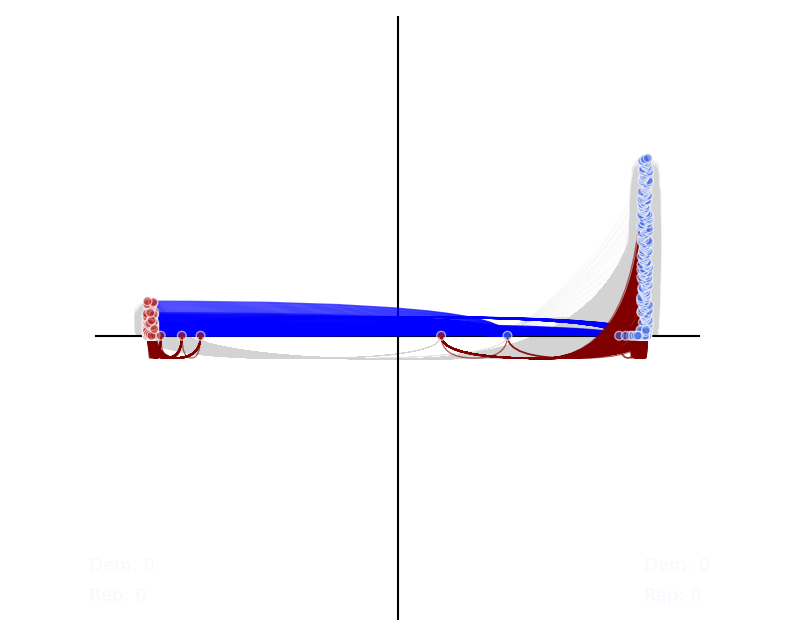

Majority party in positive x set:  ['Republican']
Majority party in negative x set:  ['Democrat']
-------------------------------------------
Congress:  110
N. misplaced Democrats:  0
N. misplaced Republicans:  1
Intersection with successive congress: 
Among Democrats:  0
Among Republicans:  0
List of misplaced Democrats:  set()
List of misplaced Republicans:  {('PAUL, Ronald Ernest', -0.2080970057855357)}
Conserved misplaced Democrats:  set()
Conserved misplaced Republicans:  set()
party switchers:  set() set()


In [17]:
cong = '110'

temp = pd.read_csv('../dataset/thresholds/house_clausen_thresholds/'+clausen_cat+'/' + cong + '_dic_thresholds_norm.csv')
threshold_pos = temp.iloc[0]['pos_threshold']
threshold_neg = temp.iloc[0]['neg_threshold']

_, x_pos_dic_110 = read_edgelist('../dataset/edgelists/votes_house_clausen_edges/'+clausen_cat+'/congress_' + cong + '.csv', threshold_pos, threshold_neg)

misplaced_democrats_110, misplaced_republicans_110 = findsets(x_pos_dic_110)

printinfo(cong, misplaced_democrats_110, misplaced_republicans_110, misplaced_democrats_111, misplaced_republicans_111)

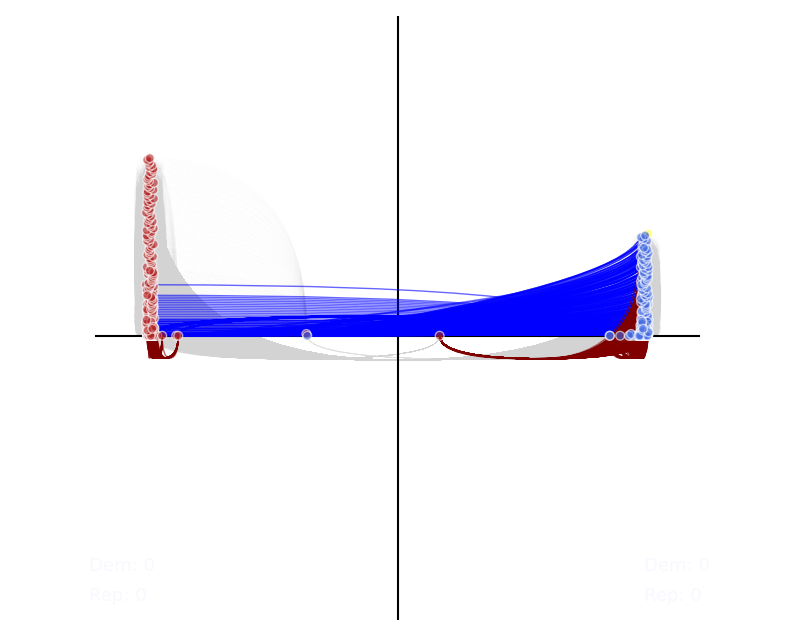

Majority party in positive x set:  ['Republican']
Majority party in negative x set:  ['Democrat']
-------------------------------------------
Congress:  109
N. misplaced Democrats:  1
N. misplaced Republicans:  2
Intersection with successive congress: 
Among Democrats:  0
Among Republicans:  0
List of misplaced Democrats:  {('SIRES, Albio', 0.4303219926932934)}
List of misplaced Republicans:  {('PAUL, Ronald Ernest', -0.20109964440092762), ('SANDERS, Bernard', -1.1941324334890404)}
Conserved misplaced Democrats:  set()
Conserved misplaced Republicans:  set()
party switchers:  set() set()


In [18]:
cong = '109'

temp = pd.read_csv('../dataset/thresholds/house_clausen_thresholds/'+clausen_cat+'/' + cong + '_dic_thresholds_norm.csv')
threshold_pos = temp.iloc[0]['pos_threshold']
threshold_neg = temp.iloc[0]['neg_threshold']

_, x_pos_dic_109 = read_edgelist('../dataset/edgelists/votes_house_clausen_edges/'+clausen_cat+'/congress_' + cong + '.csv', threshold_pos, threshold_neg)

misplaced_democrats_109, misplaced_republicans_109 = findsets(x_pos_dic_109)

printinfo(cong, misplaced_democrats_109, misplaced_republicans_109, misplaced_democrats_110, misplaced_republicans_110)

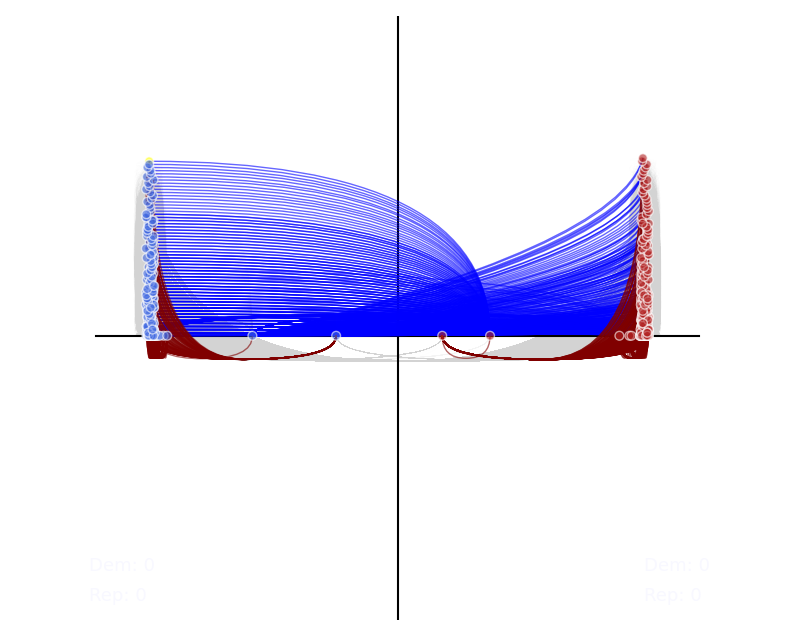

Majority party in positive x set:  ['Democrat']
Majority party in negative x set:  ['Republican']
-------------------------------------------
Congress:  108
N. misplaced Democrats:  0
N. misplaced Republicans:  1
Intersection with successive congress: 
Among Democrats:  0
Among Republicans:  0
List of misplaced Democrats:  set()
List of misplaced Republicans:  {('SANDERS, Bernard', 1.1842240450839003)}
Conserved misplaced Democrats:  set()
Conserved misplaced Republicans:  set()
party switchers:  set() set()


In [19]:
cong = '108'

temp = pd.read_csv('../dataset/thresholds/house_clausen_thresholds/'+clausen_cat+'/' + cong + '_dic_thresholds_norm.csv')
threshold_pos = temp.iloc[0]['pos_threshold']
threshold_neg = temp.iloc[0]['neg_threshold']

_, x_pos_dic_108 = read_edgelist('../dataset/edgelists/votes_house_clausen_edges/'+clausen_cat+'/congress_' + cong + '.csv', threshold_pos, threshold_neg)

misplaced_democrats_108, misplaced_republicans_108 = findsets(x_pos_dic_108)

printinfo(cong, misplaced_democrats_108, misplaced_republicans_108, misplaced_democrats_109, misplaced_republicans_109)

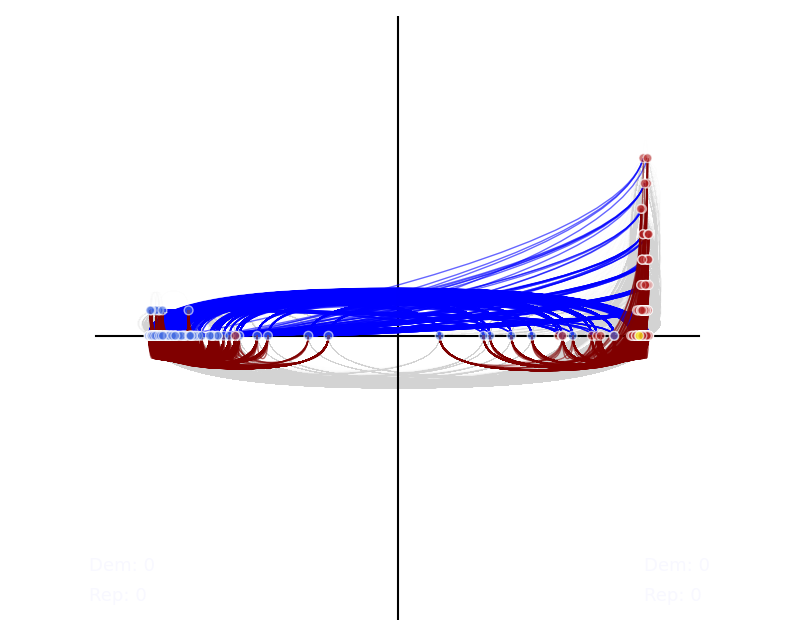

Majority party in positive x set:  ['Democrat']
Majority party in negative x set:  ['Republican']
-------------------------------------------
Congress:  107
N. misplaced Democrats:  10
N. misplaced Republicans:  2
Intersection with successive congress: 
Among Democrats:  0
Among Republicans:  0
List of misplaced Democrats:  {('MURTHA, John Patrick, Jr.', -0.4098864497303534), ('KANJORSKI, Paul E.', -0.20091148455701774), ('SISISKY, Norman', -0.7845395936740232), ('LIPINSKI, William Oliver', -0.640092898341608), ('PHELPS, David Dwain', -0.5428729739901254), ('LUCAS, Ken', -1.03399042206193), ('HALL, Ralph Moody', -1.1541396554653658), ('CRAMER, Robert E. (Bud), Jr.', -0.8355133845842653), ('TRAFICANT, James A., Jr.', -1.185157570051506), ('JOHN, Christopher', -0.44126585957677084)}
List of misplaced Republicans:  {('SANDERS, Bernard', 1.1098408969841793), ('PAUL, Ronald Ernest', 0.7731192774674815)}
Conserved misplaced Democrats:  set()
Conserved misplaced Republicans:  set()
party swit

In [20]:
cong = '107'

temp = pd.read_csv('../dataset/thresholds/house_clausen_thresholds/'+clausen_cat+'/' + cong + '_dic_thresholds_norm.csv')
threshold_pos = temp.iloc[0]['pos_threshold']
threshold_neg = temp.iloc[0]['neg_threshold']

_, x_pos_dic_107 = read_edgelist('../dataset/edgelists/votes_house_clausen_edges/'+clausen_cat+'/congress_' + cong + '.csv', threshold_pos, threshold_neg)

misplaced_democrats_107, misplaced_republicans_107 = findsets(x_pos_dic_107)

printinfo(cong, misplaced_democrats_107, misplaced_republicans_107, misplaced_democrats_108, misplaced_republicans_108)

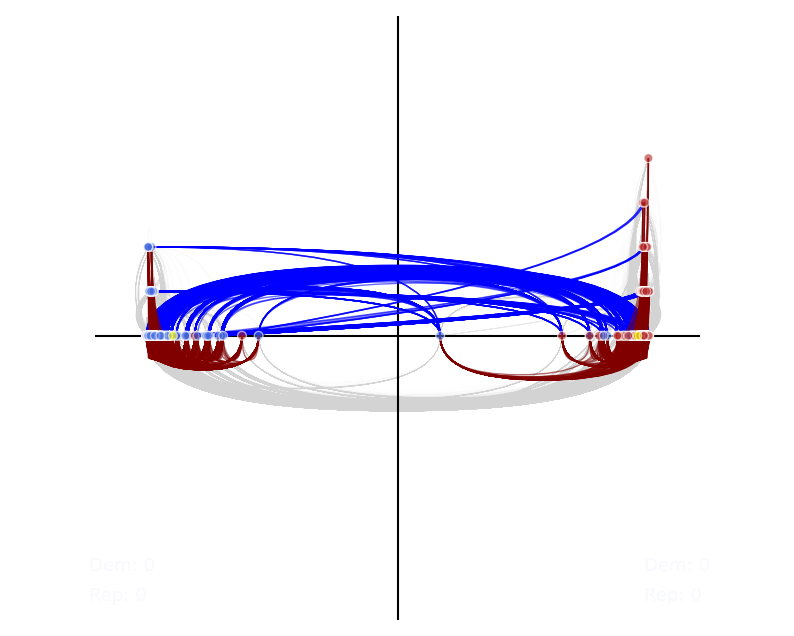

Majority party in positive x set:  ['Democrat']
Majority party in negative x set:  ['Republican']
-------------------------------------------
Congress:  106
N. misplaced Democrats:  9
N. misplaced Republicans:  5
Intersection with successive congress: 
Among Democrats:  0
Among Republicans:  0
List of misplaced Democrats:  {('SHOWS, Clifford Ronald', -0.9172095830625286), ('STENHOLM, Charles Walter', -0.20349768717447397), ('FORBES, Michael Patrick', 1.0546442811554526), ('TAYLOR, Gary Eugene (Gene)', -0.983121668799521), ('MARTÍNEZ, Matthew G.', 1.1040336943160267), ('GOODE, Virgil H., Jr.', -1.1098658090418125), ('TRAFICANT, James A., Jr.', -1.161187064692322), ('HALL, Ralph Moody', -1.1504869728775362), ('McINTYRE, Mike', -1.000475064710353)}
List of misplaced Republicans:  {('MARTÍNEZ, Matthew G.', -1.1010976901991025), ('SANDERS, Bernard', 1.0711107399974993), ('MORELLA, Constance A.', 0.9678631979162113), ('PAUL, Ronald Ernest', 0.7417109555928028), ('FORBES, Michael Patrick', -0

In [21]:
cong = '106'

temp = pd.read_csv('../dataset/thresholds/house_clausen_thresholds/'+clausen_cat+'/' + cong + '_dic_thresholds_norm.csv')
threshold_pos = temp.iloc[0]['pos_threshold']
threshold_neg = temp.iloc[0]['neg_threshold']

_, x_pos_dic_106 = read_edgelist('../dataset/edgelists/votes_house_clausen_edges/'+clausen_cat+'/congress_' + cong + '.csv', threshold_pos, threshold_neg)

misplaced_democrats_106, misplaced_republicans_106 = findsets(x_pos_dic_106)

printinfo(cong, misplaced_democrats_106, misplaced_republicans_106, misplaced_democrats_107, misplaced_republicans_107)

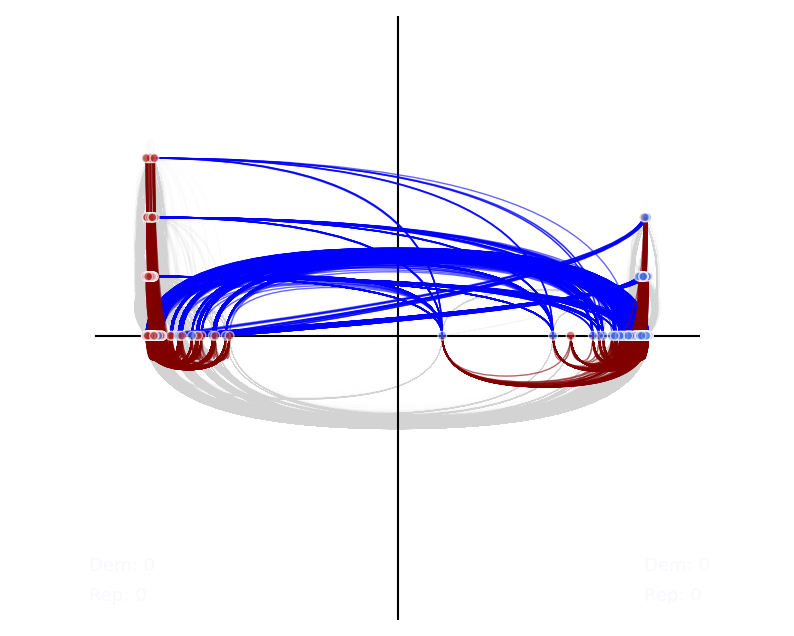

Majority party in positive x set:  ['Republican']
Majority party in negative x set:  ['Democrat']
-------------------------------------------
Congress:  105
N. misplaced Democrats:  11
N. misplaced Republicans:  4
Intersection with successive congress: 
Among Democrats:  0
Among Republicans:  0
List of misplaced Democrats:  {('JOHN, Christopher', 0.8188495720536031), ('BARCIA, James A.', 1.0360247133911864), ('McINTYRE, Mike', 1.1405110132198601), ('PETERSON, Collin Clark', 0.9803978308834373), ('CRAMER, Robert E. (Bud), Jr.', 0.8806143496314318), ('LIPINSKI, William Oliver', 1.0446266115256324), ('TAYLOR, Gary Eugene (Gene)', 1.1382105420128514), ('STENHOLM, Charles Walter', 0.9590744739226182), ('GOODE, Virgil H., Jr.', 1.1639604819916598), ('HALL, Ralph Moody', 1.16514218906418), ('TRAFICANT, James A., Jr.', 1.1706743880586314)}
List of misplaced Republicans:  {('SANDERS, Bernard', -1.1518834980578803), ('MORELLA, Constance A.', -1.095479088982792), ('SCHIFF, Steven Harvey', -1.1752

In [22]:
cong = '105'

temp = pd.read_csv('../dataset/thresholds/house_clausen_thresholds/'+clausen_cat+'/' + cong + '_dic_thresholds_norm.csv')
threshold_pos = temp.iloc[0]['pos_threshold']
threshold_neg = temp.iloc[0]['neg_threshold']

_, x_pos_dic_105 = read_edgelist('../dataset/edgelists/votes_house_clausen_edges/'+clausen_cat+'/congress_' + cong + '.csv', threshold_pos, threshold_neg)

misplaced_democrats_105, misplaced_republicans_105 = findsets(x_pos_dic_105)

printinfo(cong, misplaced_democrats_105, misplaced_republicans_105, misplaced_democrats_106, misplaced_republicans_106)

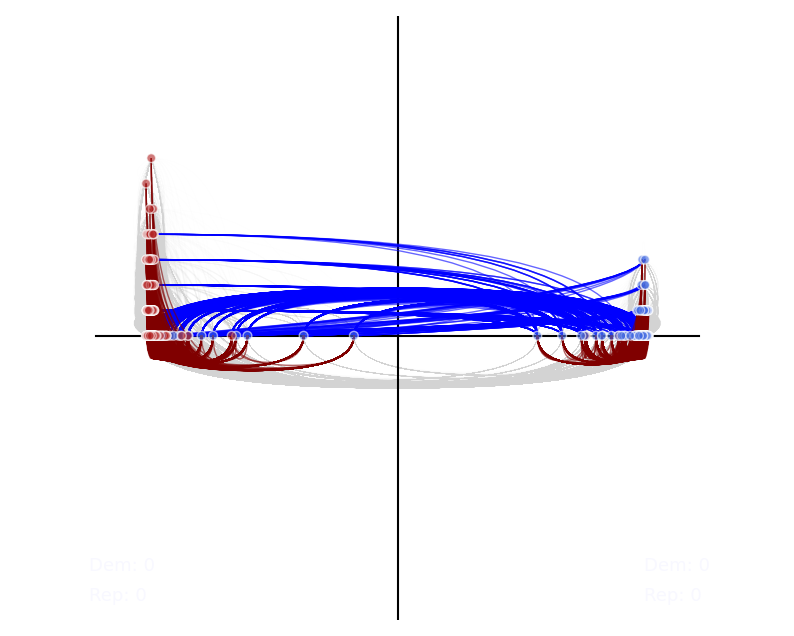

Majority party in positive x set:  ['Republican']
Majority party in negative x set:  ['Democrat']
-------------------------------------------
Congress:  104
N. misplaced Democrats:  20
N. misplaced Republicans:  4
Intersection with successive congress: 
Among Democrats:  0
Among Republicans:  0
List of misplaced Democrats:  {('MONTGOMERY, Gillespie V. (Sonny)', 1.0845841689217381), ('MURTHA, John Patrick, Jr.', 0.7156050947292723), ('BEVILL, Tom', 0.4477112905349566), ('CRAMER, Robert E. (Bud), Jr.', 1.0332247114632713), ('PICKETT, Owen Bradford', 0.20809699048560865), ('GEREN, Preston M. (Pete)', 1.1358013898998625), ('TEJEDA, Frank', 0.7689011316986243), ('SKELTON, Isaac Newton, IV (Ike)', 1.044169199359972), ('BREWSTER, William K.', 1.0679973765600195), ('STENHOLM, Charles Walter', 0.9345189398511158), ('BROWDER, John Glen', 0.9961948371323075), ('HAYES, James Allison', 1.1580584042368858), ('TRAFICANT, James A., Jr.', 1.1182899662345773), ('LAUGHLIN, Gregory H.', 1.1264453450281984

In [23]:
cong = '104'

temp = pd.read_csv('../dataset/thresholds/house_clausen_thresholds/'+clausen_cat+'/' + cong + '_dic_thresholds_norm.csv')
threshold_pos = temp.iloc[0]['pos_threshold']
threshold_neg = temp.iloc[0]['neg_threshold']

_, x_pos_dic_104 = read_edgelist('../dataset/edgelists/votes_house_clausen_edges/'+clausen_cat+'/congress_' + cong + '.csv', threshold_pos, threshold_neg)

misplaced_democrats_104, misplaced_republicans_104 = findsets(x_pos_dic_104)

printinfo(cong, misplaced_democrats_104, misplaced_republicans_104, misplaced_democrats_105, misplaced_republicans_105)

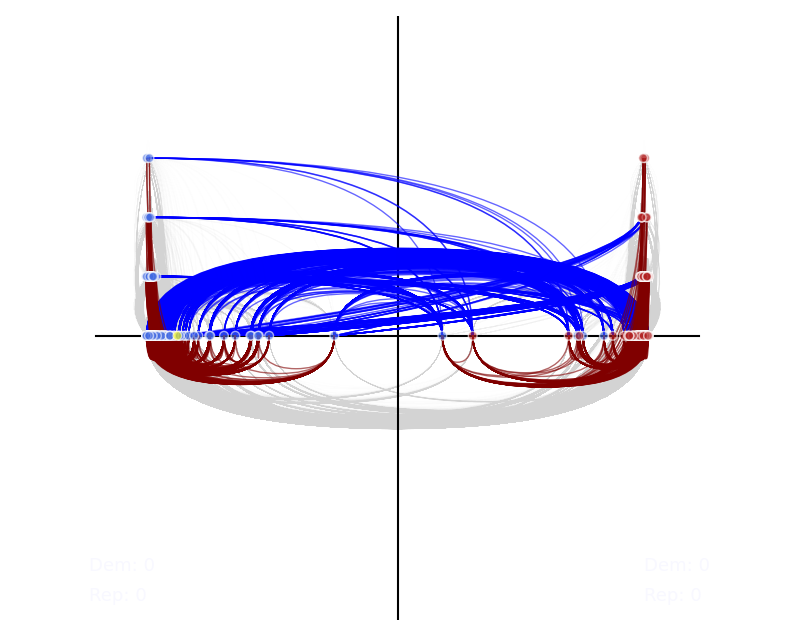

Majority party in positive x set:  ['Democrat']
Majority party in negative x set:  ['Republican']
-------------------------------------------
Congress:  103
N. misplaced Democrats:  4
N. misplaced Republicans:  1
Intersection with successive congress: 
Among Democrats:  0
Among Republicans:  0
List of misplaced Democrats:  {('TAYLOR, Gary Eugene (Gene)', -0.9844046524979659), ('TAUZIN, Wilbert Joseph (Billy)', -0.8848617353913726), ('HUTTO, Earl Dewitt', -0.2138534156071138), ('HALL, Ralph Moody', -0.857539487433187)}
List of misplaced Republicans:  {('SANDERS, Bernard', 1.0498844220046875)}
Conserved misplaced Democrats:  set()
Conserved misplaced Republicans:  set()
party switchers:  set() set()


In [24]:
cong = '103'

temp = pd.read_csv('../dataset/thresholds/house_clausen_thresholds/'+clausen_cat+'/' + cong + '_dic_thresholds_norm.csv')
threshold_pos = temp.iloc[0]['pos_threshold']
threshold_neg = temp.iloc[0]['neg_threshold']

_, x_pos_dic_103 = read_edgelist('../dataset/edgelists/votes_house_clausen_edges/'+clausen_cat+'/congress_' + cong + '.csv', threshold_pos, threshold_neg)

misplaced_democrats_103, misplaced_republicans_103 = findsets(x_pos_dic_103)

printinfo(cong, misplaced_democrats_103, misplaced_republicans_103, misplaced_democrats_104, misplaced_republicans_104)

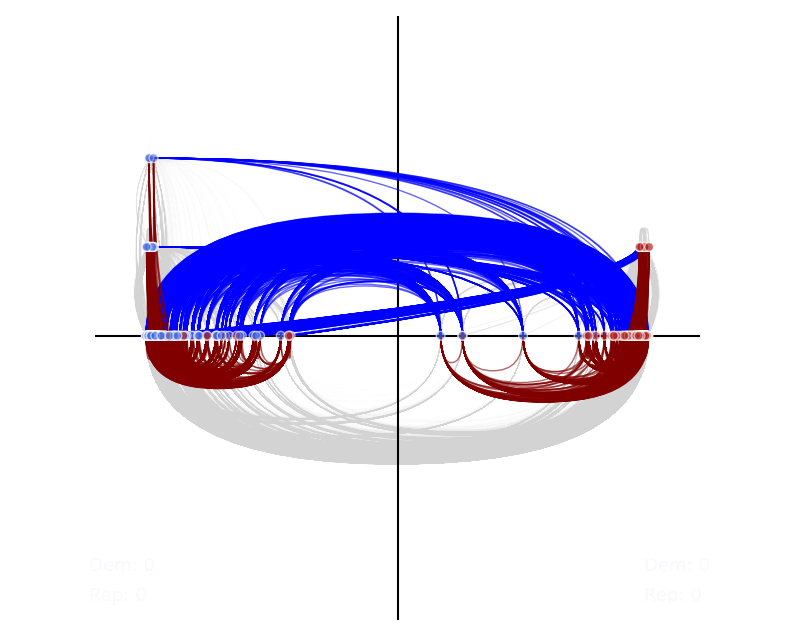

Majority party in positive x set:  ['Democrat']
Majority party in negative x set:  ['Republican']
-------------------------------------------
Congress:  102
N. misplaced Democrats:  6
N. misplaced Republicans:  9
Intersection with successive congress: 
Among Democrats:  0
Among Republicans:  0
List of misplaced Democrats:  {('HALL, Ralph Moody', -0.9107885871009125), ('TAUZIN, Wilbert Joseph (Billy)', -0.8638383454864045), ('HUTTO, Earl Dewitt', -0.9318333416730407), ('HUBBARD, Carroll, Jr.', -0.20571137955026683), ('MONTGOMERY, Gillespie V. (Sonny)', -0.30938679722958595), ('STENHOLM, Charles Walter', -0.5985489220217604)}
List of misplaced Republicans:  {('MADIGAN, Edward Rell', 0.8225252629091904), ('CONTE, Silvio Ottavio', 0.863530332348319), ('BOEHLERT, Sherwood Louis', 0.5194883740550926), ('ROUKEMA, Margaret Scafati', 0.9061560586712551), ('BARTLETT, Harry Stephen (Steve)', 0.7679801273424751), ('GREEN, Sedgwick William (Bill)', 1.02068183592617), ('MORELLA, Constance A.', 1.102

In [25]:
cong = '102'

temp = pd.read_csv('../dataset/thresholds/house_clausen_thresholds/'+clausen_cat+'/' + cong + '_dic_thresholds_norm.csv')
threshold_pos = temp.iloc[0]['pos_threshold']
threshold_neg = temp.iloc[0]['neg_threshold']

_, x_pos_dic_102 = read_edgelist('../dataset/edgelists/votes_house_clausen_edges/'+clausen_cat+'/congress_' + cong + '.csv', threshold_pos, threshold_neg)

misplaced_democrats_102, misplaced_republicans_102 = findsets(x_pos_dic_102)

printinfo(cong, misplaced_democrats_102, misplaced_republicans_102, misplaced_democrats_103, misplaced_republicans_103)

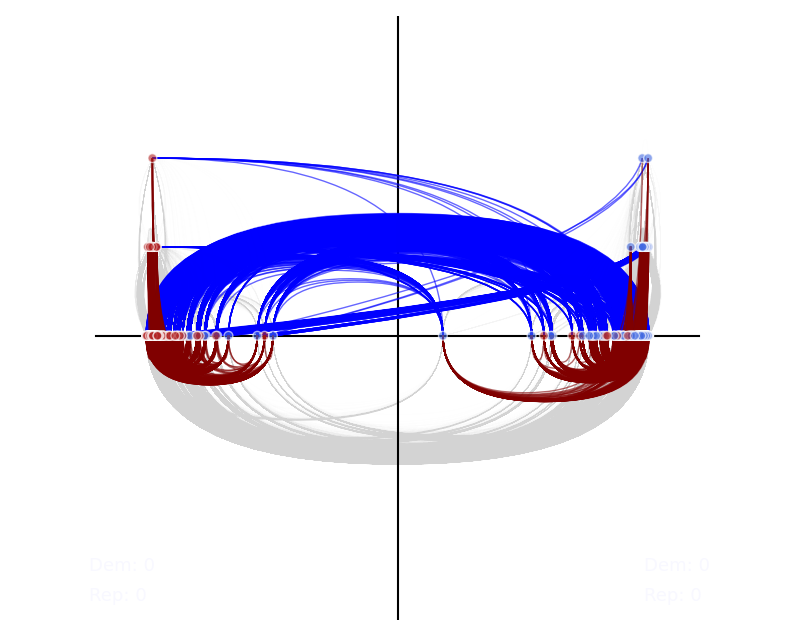

Majority party in positive x set:  ['Republican']
Majority party in negative x set:  ['Democrat']
-------------------------------------------
Congress:  101
N. misplaced Democrats:  16
N. misplaced Republicans:  14
Intersection with successive congress: 
Among Democrats:  0
Among Republicans:  0
List of misplaced Democrats:  {('HALL, Ralph Moody', 1.1308165373624441), ('HUTTO, Earl Dewitt', 1.0506128118647056), ('HUCKABY, Thomas Jerald', 0.997013334206722), ('STENHOLM, Charles Walter', 1.049235154346409), ('SARPALIUS, William', 0.9523694441413637), ('ENGLISH, Glenn Lee, Jr.', 0.9581333133771093), ('TAUZIN, Wilbert Joseph (Billy)', 1.0466139160982284), ('PARKER, Michael (Mike)', 0.9875915084566578), ('BARNARD, Druie Douglas, Jr.', 0.9200883373686808), ('WILSON, Charles', 0.6683001929572598), ('TAYLOR, Gary Eugene (Gene)', 0.5939434512365582), ('MONTGOMERY, Gillespie V. (Sonny)', 0.913981678125114), ('RAY, Richard Belmont', 1.0377125299039636), ('WATKINS, Wesley Wade', 0.8595402742662435

In [26]:
cong = '101'

temp = pd.read_csv('../dataset/thresholds/house_clausen_thresholds/'+clausen_cat+'/' + cong + '_dic_thresholds_norm.csv')
threshold_pos = temp.iloc[0]['pos_threshold']
threshold_neg = temp.iloc[0]['neg_threshold']

_, x_pos_dic_101 = read_edgelist('../dataset/edgelists/votes_house_clausen_edges/'+clausen_cat+'/congress_' + cong + '.csv', threshold_pos, threshold_neg)

misplaced_democrats_101, misplaced_republicans_101 = findsets(x_pos_dic_101)

printinfo(cong, misplaced_democrats_101, misplaced_republicans_101, misplaced_democrats_102, misplaced_republicans_102)

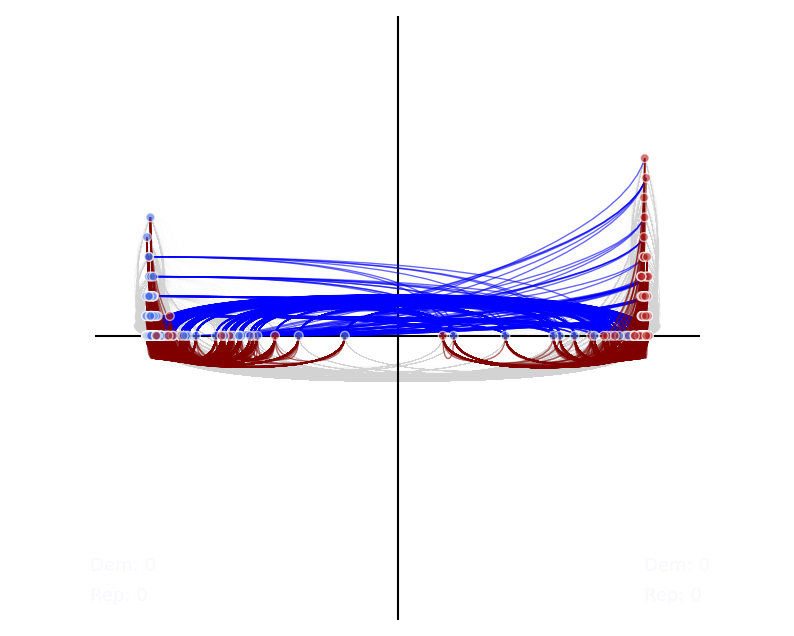

Majority party in positive x set:  ['Democrat']
Majority party in negative x set:  ['Republican']
-------------------------------------------
Congress:  100
N. misplaced Democrats:  10
N. misplaced Republicans:  10
Intersection with successive congress: 
Among Democrats:  0
Among Republicans:  0
List of misplaced Democrats:  {('HUTTO, Earl Dewitt', -1.0190737805608587), ('DANIEL, Wilbur Clarence (Dan)', -1.0862898268506962), ('ROEMER, Charles Elson (Buddy), III', -0.9388384892235504), ('HALL, Ralph Moody', -1.1024405320415809), ('NICHOLS, William Flynt', -0.5146883379842031), ('ROBINSON, Tommy Franklin', -0.8442066816869471), ('STRATTON, Samuel Studdiford', -0.773692611575844), ('STENHOLM, Charles Walter', -1.0580034640591973), ('TAUZIN, Wilbert Joseph (Billy)', -0.2678537471927318), ('MONTGOMERY, Gillespie V. (Sonny)', -0.7435432569185192)}
List of misplaced Republicans:  {('HORTON, Frank Jefferson', 1.0339692361980009), ('McKINNEY, Stewart Brett', 1.1504219491086234), ('SCHNEIDER, Cl

In [27]:
cong = '100'

temp = pd.read_csv('../dataset/thresholds/house_clausen_thresholds/'+clausen_cat+'/' + cong + '_dic_thresholds_norm.csv')
threshold_pos = temp.iloc[0]['pos_threshold']
threshold_neg = temp.iloc[0]['neg_threshold']

_, x_pos_dic_100 = read_edgelist('../dataset/edgelists/votes_house_clausen_edges/'+clausen_cat+'/congress_' + cong + '.csv', threshold_pos, threshold_neg)

misplaced_democrats_100, misplaced_republicans_100 = findsets(x_pos_dic_100)

printinfo(cong, misplaced_democrats_100, misplaced_republicans_100, misplaced_democrats_101, misplaced_republicans_101)

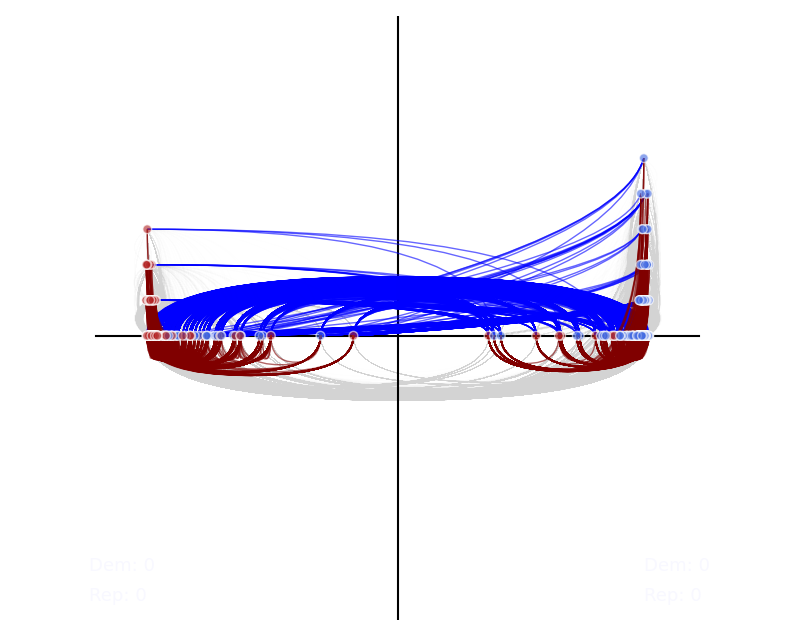

In [28]:
cong = '99'

temp = pd.read_csv('../dataset/thresholds/house_clausen_thresholds/'+clausen_cat+'/' + cong + '_dic_thresholds_norm.csv')
threshold_pos = temp.iloc[0]['pos_threshold']
threshold_neg = temp.iloc[0]['neg_threshold']

_, x_pos_dic_99 = read_edgelist('../dataset/edgelists/votes_house_clausen_edges/'+clausen_cat+'/congress_' + cong + '.csv', threshold_pos, threshold_neg)


In [29]:
print('misplaced democrats (long streaks):', misplaced_democrats_103.intersection(misplaced_democrats_104).intersection(misplaced_democrats_105).intersection(misplaced_democrats_106).intersection(misplaced_democrats_107))
print('misplaced republicans (long streaks):', misplaced_republicans_104.intersection(misplaced_republicans_105).intersection(misplaced_republicans_106).intersection(misplaced_republicans_107))

misplaced democrats (long streaks): set()
misplaced republicans (long streaks): set()
